In [60]:
from typing import List, Tuple, Iterable

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy

In [56]:
class BoltzmannMachine:
    def __init__(self, graph: nx.Graph, visible_nodes: List[int], hidden_nodes: List[int]) -> None:
        self.graph = graph
        self.num_units = len(list(self.graph.nodes))
        
        # Check valid input
        for i, j in zip(sorted(visible_nodes + hidden_nodes), range(self.num_units)):
            if i != j:
                raise ValueError(f"The given visible: {visible_nodes} and hidden: {hidden_nodes} nodes are invalid for a BM with {self.num_units} nodes")
        
        self.visible_nodes = visible_nodes
        self.hidden_nodes = hidden_nodes
        
        # Parameter initialization
        self.single_params = np.array([np.random.uniform(low=-1.0, high=1.0) for _ in range(self.num_units)])
        self.double_params = {edge: np.random.uniform(low=-1.0, high=1.0) for edge in self.graph.edges}
        
        
    def eval_energy(self, state: Tuple[int]) -> float:
        energy_sum = 0.0
        for i in range(self.num_units):
            energy_sum += -1 * (self.single_params[i] * state[i])
        
        for edge in self.graph.edges:
            energy_sum += -1 * (self.double_params[edge] * state[edge[0]] * state[edge[1]])
        
        return energy_sum
    
    
    def _gen_states(self, n: int) -> List[Tuple[int]]:
        bitstrings = []
        for i in range(int(2**n)):
            bitstrings.append(f'{i:0{n}b}')
            
        states = []
        for bitstr in bitstrings:
            state = [1 if b == '1' else -1 for b in bitstr]
            states.append(tuple(state))
        
        return states
    
    
    def _partition_function(self) -> float:
        states = self._gen_states(self.num_units)
        Z = 0
        for state in states:
            energy = self.eval_energy(state)
            Z += np.exp(-1 * energy)
        
        return Z
    
    
    def _get_combined_state(self, visible_state: Tuple[int], hidden_state: Tuple[int]) -> Tuple[int]:
        state = np.zeros(self.num_units, dtype=int)
        
        for i, s in enumerate(visible_state):
            state[self.visible_nodes[i]] = s
        
        for i, s in enumerate(hidden_state):
            state[self.hidden_nodes[i]] = s
        
        if 0 in state:
            raise ValueError(f'The combined state {state} contains an unassigned node!')
            
        return tuple(state)
    
    
    def get_distribution(self) -> dict:
        visible_states = self._gen_states(len(self.visible_nodes))
        hidden_states = self._gen_states(len(self.hidden_nodes))
        
        Z = self._partition_function()
        
        probability_dist = {}
        
        for visible_state in visible_states:
            numerator = 0
            for hidden_state in hidden_states:
                numerator += np.exp(-1 * self.eval_energy(self._get_combined_state(visible_state, hidden_state)))
            
            probability_dist[visible_state] = numerator / Z
        
        return probability_dist
    
    
    def plot_dist(self, dist: dict, data_dist: dict = None) -> None:
        fig, ax = plt.subplots(figsize=[15,5])
        xvals, yvals = [], []
        for key, val in dist.items():
            bitstring = ''.join(['1' if b == 1 else '0' for b in key])
            xvals.append(int(bitstring, 2))
            yvals.append(val)
            
        width = 0.4
        
        ax.bar(xvals, yvals, color='palegreen', label=r'$P^{model}_v$', align='edge', width=width)
        
        if data_dist is not None:
            data_xvals, data_yvals = [], []
            for key, val in data_dist.items():
                bitstring = ''.join(['1' if b == 1 else '0' for b in key])
                data_xvals.append(int(bitstring, 2))
                data_yvals.append(val)
            ax.bar(data_xvals, data_yvals, color='lightsalmon', label=r'$P^{data}_v$', align='edge', width=-width)
            
        plt.grid(alpha=.4, linestyle='--')
        plt.legend(fontsize=14)
        plt.xlabel(r'Visible state', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.show()
        plt.close()
        
        
    def log_likelihood(self, data_dist: dict, model_dist: dict) -> float:
        visible_states = self._gen_states(len(self.visible_nodes))
        
        log_likelihood = 0.0
        for visible_state in visible_states:
            p_v_data = data_dist.get(visible_state, 0)
            p_v_model = model_dist.get(visible_state, 0)
            if p_v_model > 0:
                log_likelihood -= p_v_data * np.log2(p_v_model)
        
        return log_likelihood
    
    
    def _compute_positive_phase(self, data_dist: dict, op_indices: Iterable[int], partition_func: float) -> float:
        hidden_states = self._gen_states(len(self.hidden_nodes))
        
        positive_phase = 0
        for visible_state, p_v_data in data_dist.items():
            numerator = 0
            
            for hidden_state in hidden_states:
                combined_state = self._get_combined_state(visible_state, hidden_state)
                numerator += np.prod([combined_state[i] for i in op_indices]) * np.exp(-1 * self.eval_energy(combined_state))
            
            clamped_expectation = numerator / partition_func
            positive_phase += p_v_data * clamped_expectation
        
        return positive_phase
    
    
    def _compute_negative_phase(self, op_indices: Iterable[int], partition_func: float) -> float:
        numerator = 0
        states = self._gen_states(self.num_units)
        for state in states:
            numerator += np.prod([state[i] for i in op_indices]) * np.exp(-1 * self.eval_energy(state))
        
        return numerator / partition_func
    
    
    def gradient_descent(self, data_dist: dict, step_size: float = 0.1, cutoff: float = 1e-3, max_iter: int = 100, verbose: int = 0) -> None:
        progress = 100
        cur_iter = 1
        cur_log_likelihood = self.log_likelihood(data_dist, self.get_distribution())
        while progress > cutoff and cur_iter <= max_iter:
            Z = self._partition_function()
            
            new_single_params = copy.copy(self.single_params)
            new_double_params = copy.copy(self.double_params)
            
            # update single params
            for i in range(len(self.single_params)):
                positive_phase = self._compute_positive_phase(data_dist, op_indices=[i], partition_func=Z)
                negative_phase = self._compute_negative_phase(op_indices=[i], partition_func=Z)
                delta_b_a = step_size * (positive_phase - negative_phase)
                new_single_params[i] += delta_b_a
            
            # update double params
            for edge in self.double_params.keys():
                positive_phase = self._compute_positive_phase(data_dist, op_indices=edge, partition_func=Z)
                negative_phase = self._compute_negative_phase(op_indices=edge, partition_func=Z)
                delta_w_ab = step_size * (positive_phase - negative_phase)
                new_double_params[edge] += delta_w_ab
            
            self.single_params = new_single_params
            self.double_params = new_double_params
            
            new_log_likelihood = self.log_likelihood(data_dist, self.get_distribution())
            progress = abs(new_log_likelihood - cur_log_likelihood)
            
            if verbose > 0 and (cur_iter-1) % 10 == 0:
                print(f'Finished iteration {cur_iter}:')
                print(f'\t|L_i - L_i+1| = |{cur_log_likelihood:.5f} - {new_log_likelihood:.5f}| = {progress:.5f}')
            
            cur_log_likelihood = new_log_likelihood
            cur_iter += 1

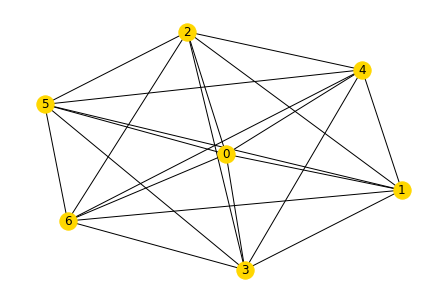

In [65]:
G = nx.generators.classic.complete_graph(7)
#G = nx.Graph()
#G.add_edges_from([(0,3), (0,4), (0,5), (0,6),
#                  (1,3), (1,4), (1,5), (1,6),
#                  (2,3), (2,4), (2,5), (2,6),])
nx.draw_spring(G, with_labels=True, node_color='gold')

visible = [0,1,2]
hidden = [3,4,5,6]
bm = BoltzmannMachine(G, visible, hidden)

0.9999999999999998
Log likelihood: L(data, model) = 6.141


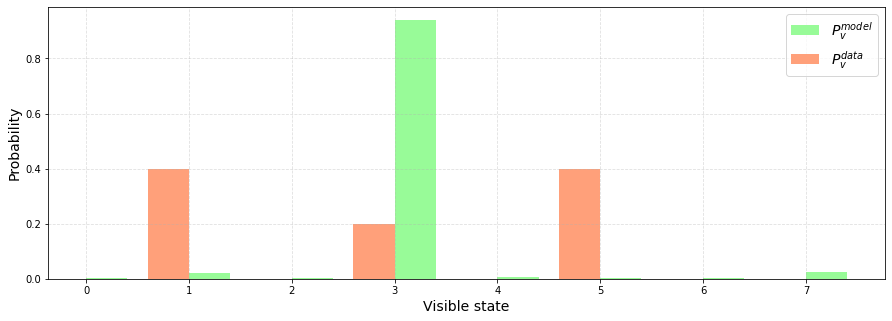

In [66]:
data_dist = {(-1, -1, 1): 0.40, (-1, 1, 1): 0.2, (1, -1, 1): 0.4}

model_dist = bm.get_distribution()
print(sum(model_dist.values()))
llh = bm.log_likelihood(data_dist, model_dist)
print(f'Log likelihood: L(data, model) = {llh:.3f}')
bm.plot_dist(model_dist, data_dist=data_dist)

Finished iteration 1:
	|L_i - L_i+1| = |6.14098 - 5.96442| = 0.17656
Finished iteration 11:
	|L_i - L_i+1| = |4.60896 - 4.49240| = 0.11656
Finished iteration 21:
	|L_i - L_i+1| = |3.76499 - 3.71393| = 0.05107
Finished iteration 31:
	|L_i - L_i+1| = |3.41088 - 3.38910| = 0.02177
Finished iteration 41:
	|L_i - L_i+1| = |3.24744 - 3.23583| = 0.01160
Finished iteration 51:
	|L_i - L_i+1| = |3.15154 - 3.14379| = 0.00774
Finished iteration 61:
	|L_i - L_i+1| = |3.08289 - 3.07688| = 0.00601
Finished iteration 71:
	|L_i - L_i+1| = |3.02738 - 3.02230| = 0.00508
Finished iteration 81:
	|L_i - L_i+1| = |2.97942 - 2.97493| = 0.00449
Finished iteration 91:
	|L_i - L_i+1| = |2.93654 - 2.93248| = 0.00406
Finished iteration 101:
	|L_i - L_i+1| = |2.89755 - 2.89384| = 0.00371
Finished iteration 111:
	|L_i - L_i+1| = |2.86185 - 2.85844| = 0.00340
Finished iteration 121:
	|L_i - L_i+1| = |2.82909 - 2.82596| = 0.00312
Finished iteration 131:
	|L_i - L_i+1| = |2.79908 - 2.79623| = 0.00285
Finished iteratio

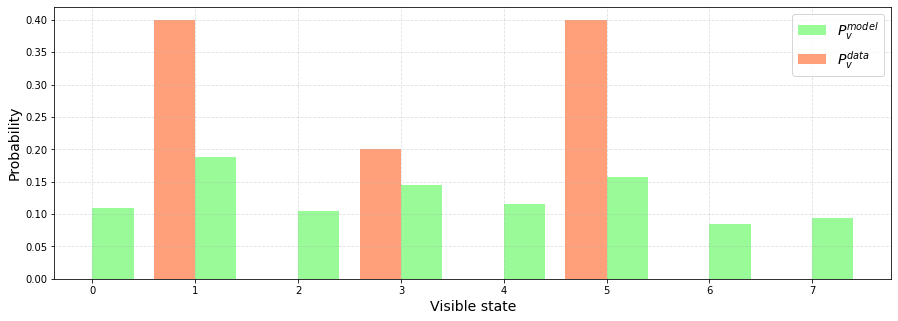

In [67]:
step_size = 0.01
cutoff = 1e-5
max_iter = 500
bm.gradient_descent(data_dist, step_size=step_size, cutoff=cutoff, max_iter=max_iter, verbose=1)
print('\nFinal Distribution:\n')
bm.plot_dist(bm.get_distribution(), data_dist=data_dist)